In [1]:
# ==============================
# STEP 1: Import libraries
# ==============================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt
import cv2
from google.colab import files

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ==============================
# STEP 2: Enable Mixed Precision (T4 Optimization)
# ==============================
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")  # uses float16 on GPU for speed

# ==============================
# STEP 3: Load MNIST dataset
# ==============================
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to (n,28,28,1) and normalize
X_train = X_train.reshape(-1,28,28,1).astype("float32") / 255.0
X_test  = X_test.reshape(-1,28,28,1).astype("float32") / 255.0

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Split validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

# ==============================
# STEP 4: Build CNN model
# ==============================
def build_model(input_shape=(28,28,1), num_classes=10, weight_decay=1e-4):
    model = models.Sequential([
        layers.Conv2D(32, 3, padding="same", kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(32, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Conv2D(64, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(64, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(128, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax", dtype="float32")  # force float32 for softmax
    ])
    return model

model = build_model()
model.summary()

# ==============================
# STEP 5: Compile & Train
# ==============================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = callbacks.ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
earlystop = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,   # Larger batch size for T4 GPU
    callbacks=[checkpoint, earlystop],
    verbose=1
)

# ==============================
# STEP 6: Evaluate on Test Set
# ==============================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")






11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             

 Total params: 157,930 (616.91 KB)

 Trainable params: 157,290 (614.41 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6414 - loss: 1.1039
Epoch 1: val_accuracy improved from -inf to 0.16833, saving model to best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.6423 - loss: 1.1013 - val_accuracy: 0.1683 - val_loss: 6.5633
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9678 - loss: 0.1171
Epoch 2: val_accuracy improved from 0.16833 to 0.35033, saving model to best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9678 - loss: 0.1170 - val_accuracy: 0.3503 - val_loss: 3.7526
Epoch 3/20
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9781 - loss: 0.0777
Epoch 3: val_accuracy improved from 0.35033 to 0.98033, saving model to best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9781 - loss: 0.0776 - val_accuracy: 0.9803 - val_loss: 0.0683
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9825 - loss: 0.0615
Epoch 4: val_accuracy did not improve from 0.98033
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9825 - loss: 0.0615 - val_accuracy: 0.9788 - val_loss: 0.0716
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9856 - loss: 0.0533
Epoch 5: val_accuracy improved from 0.98033 to 0.98450, saving model to best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9856 - loss: 0.0533 - val_accuracy: 0.9845 - val_loss: 0.0538
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9863 - loss: 0.0461
Epoch 6: val_accuracy did not improve from 0.98450
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9863 - loss: 0.0461 - val_accuracy: 0.9830 - val_loss: 0.0587
Epoch 7/20
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9877 - loss: 0.0422
Epoch 7: val_accuracy did not improve from 0.98450
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9877 - loss: 0.0422 - val_accuracy: 0.9687 - val_loss: 0.1012
Epoch 8/20
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9888 - loss: 0.0387
Epoch 8: val_accuracy improved from 0.98450 to 0.98817, saving model to best_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9888 - loss: 0.0387 - val_accuracy: 0.9882 - val_loss: 0.0384
Epoch 9/20
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9900 - loss: 0.0340
Epoch 9: val_accuracy did not improve from 0.98817
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9900 - loss: 0.0340 - val_accuracy: 0.9877 - val_loss: 0.0454
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9910 - loss: 0.0313
Epoch 10: val_accuracy did not improve from 0.98817
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9910 - loss: 0.0313 - val_accuracy: 0.9855 - val_loss: 0.0431
Epoch 11/20
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9915 - loss: 0.0288
Epoch 11: val_accuracy did not improve from 0.98817
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9915 - loss: 0.0288 - val_accuracy: 0.9867 - val_loss: 0.0540
Epoch 12/20
206/211 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9913 - loss: 0.0274
Epoch 12: val_accuracy did

In [2]:
def preprocess_image(img_path):
    """Prepare handwritten digit image for MNIST model."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # 1. Resize larger first for better thresholding
    img = cv2.resize(img, (100, 100))

    # 2. Binarize (threshold)
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # 3. Find bounding box of digit
    coords = cv2.findNonZero(img)  # all white pixels
    x, y, w, h = cv2.boundingRect(coords)
    digit = img[y:y+h, x:x+w]

    # 4. Resize digit to fit 20x20 box
    digit = cv2.resize(digit, (20, 20))

    # 5. Put into 28x28 canvas
    canvas = np.zeros((28, 28), dtype="uint8")
    x_offset = (28 - 20) // 2
    y_offset = (28 - 20) // 2
    canvas[y_offset:y_offset+20, x_offset:x_offset+20] = digit

    # 6. Normalize
    canvas = canvas.astype("float32") / 255.0
    canvas = np.expand_dims(canvas, axis=-1)  # (28,28,1)
    canvas = np.expand_dims(canvas, axis=0)   # (1,28,28,1)

    return canvas


In [3]:
def predict_digit(img_path, model):
    img = preprocess_image(img_path)
    pred = model.predict(img)
    digit = np.argmax(pred)

    plt.imshow(img[0, :, :, 0], cmap="gray")  # what model sees
    plt.title(f"Prediction: {digit}")
    plt.axis("off")
    plt.show()

    print(f"✅ Predicted Digit: {digit}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


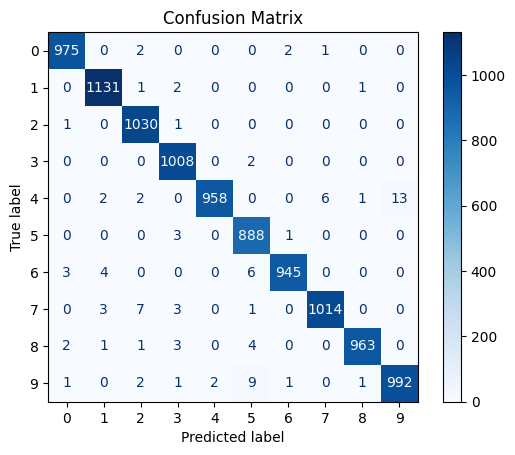

Classification Report:
              precision    recall  f1-score   support

           0     0.9929    0.9949    0.9939       980
           1     0.9912    0.9965    0.9938      1135
           2     0.9856    0.9981    0.9918      1032
           3     0.9873    0.9980    0.9926      1010
           4     0.9979    0.9756    0.9866       982
           5     0.9758    0.9955    0.9856       892
           6     0.9958    0.9864    0.9911       958
           7     0.9931    0.9864    0.9898      1028
           8     0.9969    0.9887    0.9928       974
           9     0.9871    0.9832    0.9851      1009

    accuracy                         0.9904     10000
   macro avg     0.9904    0.9903    0.9903     10000
weighted avg     0.9905    0.9904    0.9904     10000

Accuracy : 0.9904
Precision: 0.9905
Recall   : 0.9904
F1-score : 0.9904


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Get model predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Additional Metrics (overall)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


👉 Please upload a digit image (PNG/JPG)


Saving WhatsApp Image 2025-09-10 at 12.39.59_bfc8c033.jpg to WhatsApp Image 2025-09-10 at 12.39.59_bfc8c033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


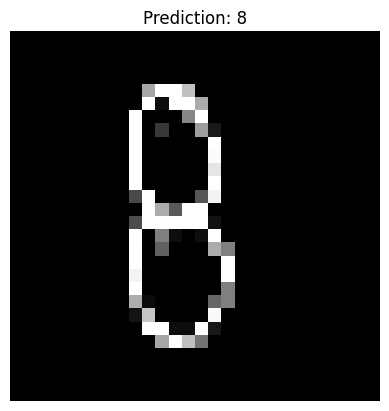

✅ Predicted Digit: 8


In [8]:
# ==============================
# STEP 8: Upload & Predict
# ==============================
print("👉 Please upload a digit image (PNG/JPG)")
uploaded = files.upload()

for filename in uploaded.keys():
    predict_digit(filename, model)

